# Getting Started

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [ ]:
train_dir = '/content/drive/MyDrive/Lyme Disease Data/RashData/Train/Train_2_Cases'
val_dir = '/content/drive/MyDrive/Lyme Disease Data/RashData/Validation/Validation_2_Cases'

In [ ]:
batch_size = 32

img_height = 128
img_width = 128

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.5,
    seed=42,
    subset='training',
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.5,
    seed=42,
    subset='validation',
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=42
)

Found 357 files belonging to 2 classes.
Using 179 files for training.
Found 357 files belonging to 2 classes.
Using 178 files for validation.
Found 87 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Lyme_Negative', 'Lyme_Positive']


# Visualization

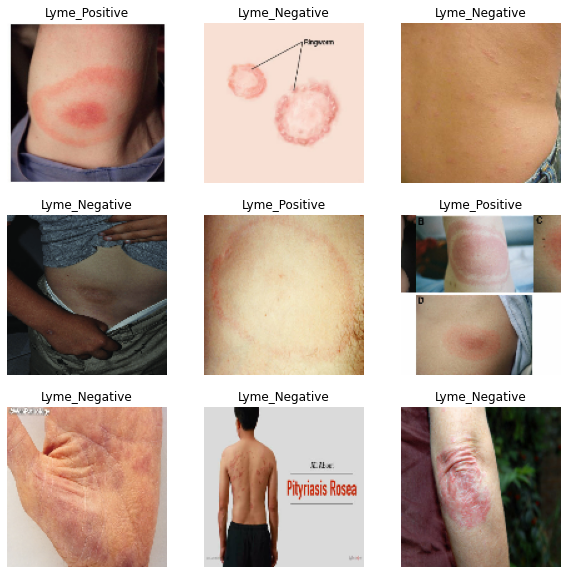

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

# Modeling

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## CNN (Functional Model)

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Accuracy

In [ ]:
model.compile(optimizer="Nadam", loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])  

In [ ]:
epochs = 200

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(patience=100)],
    verbose=1
)

Epoch 1/200
6/6 [==============================] - 31s 3s/step - loss: 0.7353 - accuracy: 0.5251 - auc: 0.5048 - val_loss: 0.6932 - val_accuracy: 0.4326 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 0s 81ms/step - loss: 0.6591 - accuracy: 0.5754 - auc: 0.6207 - val_loss: 0.6929 - val_accuracy: 0.5562 - val_auc: 0.4607 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 0s 81ms/step - loss: 0.6388 - accuracy: 0.6592 - auc: 0.6697 - val_loss: 0.6910 - val_accuracy: 0.5562 - val_auc: 0.5000 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 0s 81ms/step - loss: 0.5934 - accuracy: 0.7095 - auc: 0.7394 - val_loss: 0.6925 - val_accuracy: 0.5562 - val_auc: 0.4835 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 0s 82ms/step - loss: 0.4588 - accuracy: 0.7486 - auc: 0.8501 - val_loss: 0.6930 - val_accuracy: 0.5337 - val_auc: 0.4716 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 1s 104ms/step - loss: 0.4

# Results

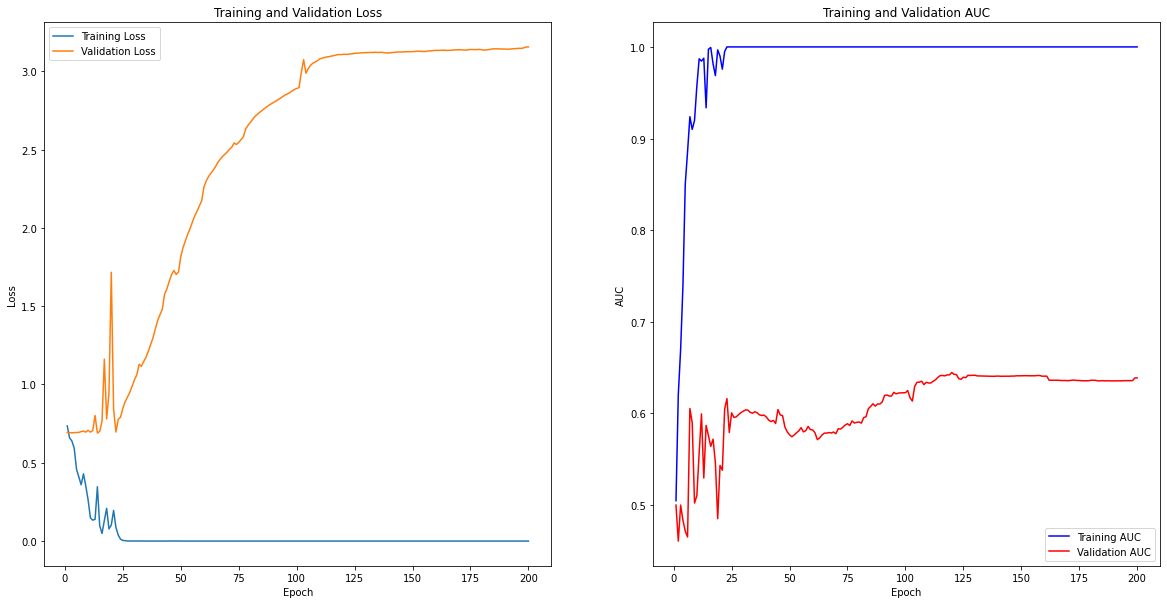

In [ ]:
plt.figure(figsize=(20, 10))

epochs_range = range(1, epochs + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_auc, label="Training AUC", color='b')
plt.plot(epochs_range, val_auc, label="Validation AUC", color='r')

plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Training and Validation AUC")
plt.legend()

plt.show()

In [ ]:
np.argmin(val_loss)

13

In [ ]:
np.argmax(val_auc)

119

In [ ]:
model.evaluate(test_ds)

3/3 [==============================] - 10s 140ms/step - loss: 2.4587 - accuracy: 0.6782 - auc: 0.7282


[2.458721160888672, 0.6781609058380127, 0.7282134890556335]

In [ ]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
label_dict = {0:'Lyme_Negative', 1:'Lyme_Positive'}

In [ ]:
# Prediction on external image...

img = cv2.imread(r'/content/drive/MyDrive/download.jpg')
img = cv2.resize(img, (128,128))
img_final =np.reshape(img, (1,img_height, img_width,3))

In [ ]:
model.predict(img_final)

array([[0.07009801]], dtype=float32)

In [ ]:
if model.predict(img_final) > 0.7:
  prediction=1
else:
  prediction=0

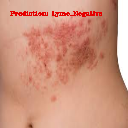

In [ ]:
img_pred = label_dict[prediction]
cv2.putText(img, "Prediction: " + img_pred, (10,15), cv2.FONT_HERSHEY_TRIPLEX, 0.2, color = (0,0,230))
cv2.putText(img, "Prediction: " + img_pred, (20,410), cv2.FONT_HERSHEY_DUPLEX, 1.3, color = (0,0,230))
cv2_imshow(img)